In [26]:
from sklearn.linear_model import Perceptron
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import time
import pickle

In [27]:
from activation_function import ReLU,Sigmoid,Softmax
from nn_layer import FC,Conv,MaxPool
from criterion import CrossEntropyLoss,SGDMomentum

# Model

In [28]:
def restruct_img(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img_gray, (32,32))
    return img


# loss plot
def loss_plot(epoch,loss_list,i):
    #fig = plt.figure(1)	#identifies the figure 
    plt.plot([i for i in range(epoch)], loss_list)
    plt.xlabel("minibatch",fontsize='13')
    plt.ylabel("loss",fontsize='13')
    plt.grid()
    plt.savefig(f'scale{i}_loss.png')
    #plt.clf()

# TwolayerNN

In [ ]:
class TwolayerNN():

    def __init__(self,D_in,H,D_out,weights=""):
        self.FC1 = FC(D_in,H)
        self.Sigmoid = Sigmoid()
        self.FC2 = FC(H,D_out)

    def _forward(self,X):
        h1 = self.FC1._forward(X)
        a1 = self.Sigmoid._forward(h1)
        h2 = self.FC2._forward(a1)
        return h2

    def _backward(self,up_grad):
        up_grad = self.FC2._backward(up_grad)
        up_grad = self.Sigmoid._backward(up_grad)
        up_grad = self.FC1._backward(up_grad)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b] = params


In [ ]:
# TwolayerNN


class train_TwolayerNN():

    def __init__(self,epoch,batch):
        self.epoch = epoch
        self.batch = batch
        self.model = TwolayerNN(1024,64,50)
        self.optim = SGDMomentum(self.model.get_params(), lr=0.0001, momentum=0.80, reg=0.0003)
        self.criterion = CrossEntropyLoss()

    def encode_label(self,y):
        enc_y = np.zeros((y.shape[0],50))
        for idx,label in enumerate(y):
            enc_y[idx,label] = 1
        return enc_y

    def fit(self,X,y):
        loss_list = []
        # flatten image
        X = X.reshape(X.shape[0],-1)

        for i in range(self.epoch):

            # training by minibatch
            minibatch = np.array_split(range(X.shape[0]),self.batch)
            for mini in minibatch:
                # One-hot encoding y
                Y_True = self.encode_label(y[mini])
                # forward
                Y_pred = self.model._forward(X[mini])
                # get loss
                loss = self.criterion._forward(Y_pred, Y_True)
                # backward
                up_grad = self.criterion._backward()
                self.model._backward(up_grad)
                self.optim.step()

                loss_list.append(loss)
            return loss_list

    def predict(self,X,y):
        X = X.reshape(X.shape[0],-1)
        Y_pred = self.model._forward(X)
        top1,top5 = self.evaluate(Y_pred,y)
        print(top1,top5)

    def evaluate(self,Y_pred, Y_True):
        # Top-1
        pred_label = np.argmax(Y_pred, axis=1)
        top1 = str(round(sum(Y_True == pred_label)/(1.0*len(Y_True)), 4))

        # Top-5
        size = Y_True.shape[0]
        count = 0
        for i in range(size):
            top5 = np.argpartition(Y_pred[i],-5)[-5:]
            if Y_True[i] in top5:
                count += 1
        top5 = str(round(count/size,4))

        return top1,top5

# LeNet5

In [29]:
class LeNet5():

    def __init__(self):
        self.C1 = Conv(1,6,5)
        self.Sigmoid1 = Sigmoid()
        self.S2 = MaxPool(2,2)
        self.C3 = Conv(6,16,5)
        self.Sigmoid2 = Sigmoid()
        self.S4 = MaxPool(2,2)
        self.FC5 = FC(16*5*5,120)
        self.ReLU3 = ReLU()
        self.FC6 = FC(120,84)
        self.ReLU4 = ReLU()
        self.FC7 = FC(84,50)
        self.a2shape = None

    def _forward(self,X):

        h1 = self.C1._forward(X)
        a1 = self.Sigmoid1._forward(h1)
        s1 = self.S2._forward(a1)

        h2 = self.C3._forward(s1)
        a2 = self.Sigmoid2._forward(h2)
        s2 = self.S4._forward(a2)

        self.a2shape = s2.shape
        f1 = s2.reshape(s2.shape[0],-1)

        h3 = self.FC5._forward(f1)
        a3 = self.ReLU3._forward(h3)

        h4 = self.FC6._forward(a3)
        a4 = self.ReLU4._forward(h4)

        h5 = self.FC7._forward(a4)
        return h5

    def _backward(self, up_grad):

        up_grad = self.FC7._backward(up_grad)
        up_grad = self.ReLU4._backward(up_grad)
        up_grad = self.FC6._backward(up_grad)
        up_grad = self.ReLU3._backward(up_grad)
        up_grad = self.FC5._backward(up_grad)
        up_grad = up_grad.reshape(self.a2shape)
        up_grad = self.S4._backward(up_grad)
        up_grad = self.Sigmoid2._backward(up_grad)
        up_grad = self.C3._backward(up_grad)
        up_grad = self.S2._backward(up_grad)
        up_grad = self.Sigmoid1._backward(up_grad)
        up_grad = self.C1._backward(up_grad)

    def get_params(self):
        return [self.C1.W, self.C1.b,
                self.C3.W, self.C3.b,
                self.FC5.W,self.FC5.b,
                self.FC6.W,self.FC6.b,
                self.FC7.W,self.FC7.b,]

    def set_params(self, params):
        [self.C1.W, self.C1.b,self.C3.W, self.C3.b,self.FC5.W,self.FC5.b,self.FC6.W,self.FC6.b,self.FC7.W,self.FC7.b,] = params  

In [30]:
class impLeNet5():

    def __init__(self):
        self.C1 = Conv(1,6,3)
        self.Sigmoid1 = Sigmoid()
        self.S2 = MaxPool(2,2)
        self.C3 = Conv(6,10,3)
        self.Sigmoid2 = Sigmoid()
        self.S4 = MaxPool(2,2)
        self.C5 = Conv(10,16,3)
        self.Sigmoid3 = Sigmoid()
        self.S6 = MaxPool(2,2)
        self.FC7 = FC(16*3*3,120)
        self.ReLU4 = ReLU()
        self.FC8 = FC(120,84)
        self.ReLU5 = ReLU()
        self.FC9 = FC(84,50)

        self.a2shape = None
        self.h1, self.h2, self.h3, self.h4, self.h5 = None, None, None, None, None
        self.a1, self.a2, self.a3, self.a4, self.a5 = None, None, None, None, None

    def _forward(self,X):

        self.h1 = self.C1._forward(X)
        self.a1 = self.Sigmoid1._forward(self.h1)
        a1_ = self.a1 * self.h1
        s1 = self.S2._forward(a1_)

        self.h2 = self.C3._forward(s1)
        self.a2 = self.Sigmoid2._forward(self.h2)
        a2_ = self.a2*self.h2
        s2 = self.S4._forward(a2_)

        self.h3 = self.C5._forward(s2)
        self.a3 = self.Sigmoid3._forward(self.h3)
        a3_ = self.a3*self.h3
        s3 = self.S6._forward(a3_)

        self.a2shape = s3.shape
        f1 = s3.reshape(s3.shape[0],-1)

        self.h4 = self.FC7._forward(f1)
        self.a4 = self.ReLU4._forward(self.h4)
        #a4_ = self.a4*self.h4

        self.h5 = self.FC8._forward(self.a4)
        self.a5 = self.ReLU5._forward(self.h5)
        #a5_ = self.a5*self.h5

        h6 = self.FC9._forward(self.a5)
        return h6

    def _backward(self, up_grad):

        up_grad = self.FC9._backward(up_grad)

        #partial_up_grad = up_grad*self.h5
        #partial_up_grad = self.ReLU5._backward(partial_up_grad)
        #partial_up_grad2 = up_grad*self.a5
        #up_grad = partial_up_grad+partial_up_grad2
        up_grad = self.ReLU5._backward(up_grad)
        up_grad = self.FC8._backward(up_grad)

        #partial_up_grad = up_grad*self.h4
        #partial_up_grad = self.ReLU4._backward(partial_up_grad)
        #partial_up_grad2 = up_grad*self.a4
        #up_grad = partial_up_grad+partial_up_grad2
        up_grad = self.ReLU4._backward(up_grad)
        up_grad = self.FC7._backward(up_grad)

        up_grad = up_grad.reshape(self.a2shape)

        up_grad = self.S6._backward(up_grad)

        partial_up_grad = up_grad*self.h3
        partial_up_grad = self.Sigmoid3._backward(partial_up_grad)
        partial_up_grad2 = up_grad*self.a3
        up_grad = partial_up_grad+partial_up_grad2
        up_grad = self.C5._backward(up_grad)

        up_grad = self.S4._backward(up_grad)
        partial_up_grad = up_grad*self.h2
        partial_up_grad = self.Sigmoid2._backward(partial_up_grad)
        partial_up_grad2 = up_grad*self.a2
        up_grad = partial_up_grad+partial_up_grad2
        up_grad = self.C3._backward(up_grad)

        up_grad = self.S2._backward(up_grad)
        partial_up_grad = up_grad*self.h1
        partial_up_grad = self.Sigmoid1._backward(partial_up_grad)
        partial_up_grad2 = up_grad*self.a1
        up_grad = partial_up_grad+partial_up_grad2
        up_grad = self.C1._backward(up_grad)

    def get_params(self):
        return [self.C1.W, self.C1.b,
                self.C3.W, self.C3.b,
                self.C5.W, self.C5.b,
                self.FC7.W,self.FC7.b,
                self.FC8.W,self.FC8.b,
                self.FC9.W,self.FC9.b,]

    def set_params(self, params):
        [self.C1.W, self.C1.b,self.C3.W, self.C3.b, self.C5.W, self.C5.b,
         self.FC7.W,self.FC7.b,self.FC8.W,self.FC8.b,self.FC9.W,self.FC9.b,] = params  

In [31]:
class train_LeNet5():

    def __init__(self,epoch,batch):
        self.epoch = epoch
        self.batch = batch
        self.model = LeNet5()
        self.optim = SGDMomentum(self.model.get_params(), lr=0.0001, momentum=0.80, reg=0.0003)
        self.criterion = CrossEntropyLoss()

    def encode_label(self,y):
        enc_y = np.zeros((y.shape[0],50))
        for idx,label in enumerate(y):
            enc_y[idx,label] = 1
        return enc_y

    def fit(self,X,y):
        loss_list = []
        # reshape image for training
        N,H,W = X.shape
        X = X.reshape(N,1,H,W)

        for i in range(self.epoch):
            print(f"Trianing epoch {i}")
            start = time.time()
            # training by minibatch
            idx = np.random.permutation(X.shape[0])
            X, y = X[idx], y[idx]
            minibatch = np.array_split(range(X.shape[0]),self.batch)
            j = 1
            for mini in minibatch:

                # One-hot encoding y
                Y_True = self.encode_label(y[mini])
                # forward
                Y_pred = self.model._forward(X[mini])
                # get loss
                loss = self.criterion._forward(Y_pred, Y_True)

                # backward
                up_grad = self.criterion._backward()
                self.model._backward(up_grad)
                self.optim.step()

                loss_list.append(loss)

                if j % 10 == 0:
                    print(f"minibatch:{j},loss={loss}")
                    time.sleep(0.3)
                j = j+1
            end = time.time()
            train_time = end-start
            print(f'training time = {train_time}')
        return loss_list,train_time

    def predict(self,X,y):
        # reshape image for training
        N,H,W = X.shape
        X = X.reshape(N,1,H,W)
        Y_pred = self.model._forward(X)
        top1,top5 = self.evaluate(Y_pred,y)
        print(top1,top5)
        return Y_pred

    def evaluate(self,Y_pred, Y_True):
        # Top-1
        pred_label = np.argmax(Y_pred, axis=1)
        top1 = str(round(sum(Y_True == pred_label)/(1.0*len(Y_True)), 4))

        # Top-5
        size = Y_True.shape[0]
        count = 0
        for i in range(size):
            top5 = np.argpartition(Y_pred[i],-5)[-5:]
            if Y_True[i] in top5:
                count += 1
        top5 = str(round(count/size,4))

        return top1,top5

# train

In [8]:
train = 'train.txt'
val = 'val.txt'
test = 'test.txt'
train = pd.read_csv(train, delimiter=" ", header=None)
val = pd.read_csv(val, delimiter=" ", header=None)
test = pd.read_csv(test, delimiter=" ", header=None)

train.columns = ['image', 'label']
val.columns = ['image', 'label']
test.columns = ['image', 'label']

train['image'] = train['image'].apply(restruct_img)
val['image'] = val['image'].apply(restruct_img)
test['image'] = test['image'].apply(restruct_img)

X_train = np.array(list(train['image'].values))
y_train = np.array(train['label'])
X_val = np.array(list(val['image'].values))
y_val = np.array(val['label'])
X_test = np.array(list(test['image'].values))
y_test = np.array(test['label'])

In [ ]:
############# trian TwoLayerNN#####################
train_2layer = train_TwolayerNN(10, 500)
loss = train_2layer.fit(X_train,y_train)
val_y = train_2layer.predict(X_val,y_val)
test_y = train_2layer.predict(X_test,y_test)

In [ ]:
############# trian LeNet5#####################
train_model = train_LeNet5(1, 200)
loss_list_,time_ = train_model.fit(X_train,y_train)

Trianing epoch 0
minibatch:10,loss=1318.0705041334493
minibatch:20,loss=1267.5005383357359
minibatch:30,loss=1265.6532265465946


In [41]:
val_y = train_model.predict(X_val,y_val)
# 0.02 0.1

test_y = train_model.predict(X_test,y_test)

0.02 0.1
0.02 0.1


In [ ]:
############# trian imporve LeNet5#####################
imp_train_model = train_LeNet5(1, 200)

loss_list_,time = imp_train_model.fit(X_train,y_train)

In [ ]:
val_y = imp_train_model.predict(X_val,y_val)
# 0.02 0.1

test_y = imp_train_model.predict(X_test,y_test)

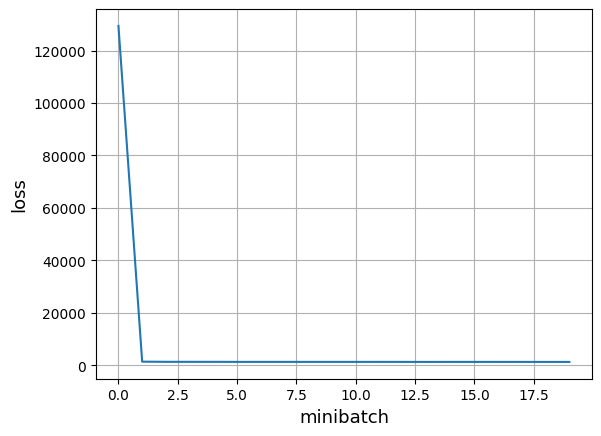

In [40]:
loss_plot(20,loss_list_[::10],'leNet-5')